# Evaluation Metrics for Classification


## Dataset

Dataset is Credit Card Data from book "Econometric Analysis" - [Link](https://github.com/Ksyula/ML_Engineering/blob/master/04-evaluation/AER_credit_card_data.csv)

Here's a wget-able [link](https://github.com/Ksyula/ML_Engineering/blob/master/04-evaluation/AER_credit_card_data.csv):

```bash
wget https://raw.githubusercontent.com/Ksyula/ML_Engineering/master/04-evaluation/AER_credit_card_data.csv
```

The goal is to inspect the output of different evaluation metrics by creating a classification model (target column `card`).

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

np.__version__, pd.__version__

('1.21.5', '1.4.3')

In [3]:
data = pd.read_csv("AER_credit_card_data.csv")
data.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [4]:
# Create the target variable by mapping `yes` to 1 and `no` to 0.
data.card = (data.card == "yes").astype(int)

## Exploratory Data Analysis

In [5]:
data.isna().sum()

card           0
reports        0
age            0
income         0
share          0
expenditure    0
owner          0
selfemp        0
dependents     0
months         0
majorcards     0
active         0
dtype: int64

In [6]:
data.dtypes

card             int64
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [7]:
categorical = data.dtypes[data.dtypes == "object"].index.tolist()
numerical = data.dtypes[data.dtypes != "object"].index.tolist()
categorical, numerical

(['owner', 'selfemp'],
 ['card',
  'reports',
  'age',
  'income',
  'share',
  'expenditure',
  'dependents',
  'months',
  'majorcards',
  'active'])

In [8]:
global_card = (data.card == 'yes').mean()
from IPython.display import display

for c in categorical:
    print(c)
    df_group = data.groupby(c).card.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_card
    df_group['risk'] = df_group['mean'] / global_card
    display(df_group)
    print()

owner


,mean,count,diff,risk
owner,,,,
no,0.720867,738,0.720867,inf
yes,0.845095,581,0.845095,inf



selfemp


,mean,count,diff,risk
selfemp,,,,
no,0.781759,1228,0.781759,inf
yes,0.692308,91,0.692308,inf


## Set up validation framework
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.

In [9]:
df_train_full, df_test = train_test_split(data, test_size = 0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size = 0.25, random_state=1)

df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train["card"]
del df_val["card"]
del df_test["card"]

## Feature importance: ROC AUC
### Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- **`share`**

In [11]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [12]:
df_train.dtypes

reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [13]:
numerical = df_train.dtypes[df_train.dtypes != "object"].index.tolist()
numerical

['reports',
 'age',
 'income',
 'share',
 'expenditure',
 'dependents',
 'months',
 'majorcards',
 'active']

In [14]:
score = {}

for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    score[c] = auc
{k: v for k, v in sorted(score.items(), key=lambda item: item[1])}

{'age': 0.5240020979407055,
 'months': 0.5294217780967629,
 'dependents': 0.5327757227773791,
 'majorcards': 0.5343859842838476,
 'income': 0.5908049467233478,
 'active': 0.6043173411362006,
 'reports': 0.7166629860689376,
 'share': 0.989183643423692,
 'expenditure': 0.991042345276873}

negative correlation: reports
negative correlation: dependents
positive correlation: active
positive correlation: share


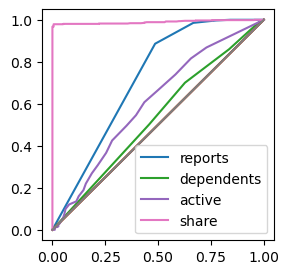

In [15]:
plt.figure(figsize=(3, 3))
for c in ['reports', 'dependents', 'active', 'share']:
    if roc_auc_score(y_train, df_train[c]) >= 0.5:
        fpr, tpr, _ = roc_curve(y_train, df_train[c])
        print("positive correlation:" , c)
    else:
        fpr, tpr, _ = roc_curve(y_train, -df_train[c])
        print("negative correlation:" , c)
    plt.plot(fpr, tpr, label= c)
    plt.plot([0, 1], [0, 1])
plt.legend()
plt.show()

We can see that there's separation in distribution of share between positive and negative classes (this is what AUC tells us about)

In [16]:
data.groupby(['card']).share.mean()

card
0    0.000477
1    0.088482
Name: share, dtype: float64

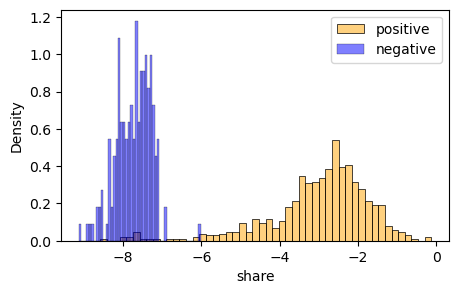

In [17]:
plt.figure(figsize=(5, 3))
sns.histplot(np.log(df_train.share[y_train == 1]),
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(np.log(df_train.share[y_train == 0]),
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()

For negative examples (blue) the values of share tend to be significantly lower. That's why AUC is above 0.5 - the correlation is positive.

For `reports` and `dependents` variables we have to reverse the order by negating the values, the positive examples will tend to have higher values than negative.

## Train Logistic Regression
From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [18]:
cols = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
set(df_train).difference(set(cols))


set()

In [19]:
# prepare train data
dv = DictVectorizer(sparse = False)
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

# train model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# prepare validation data
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

# Predict on validation set
y_pred = model.predict_proba(X_val)[:, 1]

In [20]:
dv.feature_names_

['active',
 'age',
 'dependents',
 'expenditure',
 'income',
 'majorcards',
 'months',
 'owner=no',
 'owner=yes',
 'reports',
 'selfemp=no',
 'selfemp=yes',
 'share']

## Evaluate the model
### Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- **0.995**

In [21]:
# probability
roc_auc_score(y_val, y_pred).round(3)

0.995

In [22]:
# hard predictions
y_pred_bin = model.predict(X_val)
roc_auc_score(y_val, y_pred_bin)

0.9739783600107306

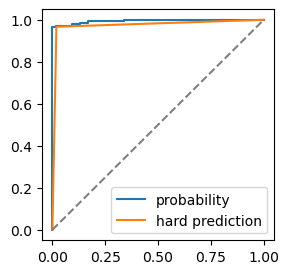

In [23]:
plt.figure(figsize=(3, 3))

fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='probability')

fpr, tpr, _ = roc_curve(y_val, y_pred_bin)
plt.plot(fpr, tpr, label='hard prediction')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

### Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.1
* **0.3**
* 0.6
* 0.8

In [24]:
thresholds = np.linspace(0, 1, 101)
precision, recall = [], []

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

scores = []

for t in thresholds:
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))
    
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

df_scores[(df_scores.p == df_scores.r)]

,threshold,tp,fp,fn,tn,p,r
24,0.24,206,5,5,48,0.976303,0.976303
25,0.25,206,5,5,48,0.976303,0.976303
26,0.26,206,5,5,48,0.976303,0.976303
27,0.27,206,5,5,48,0.976303,0.976303
28,0.28,206,5,5,48,0.976303,0.976303
29,0.29,206,5,5,48,0.976303,0.976303


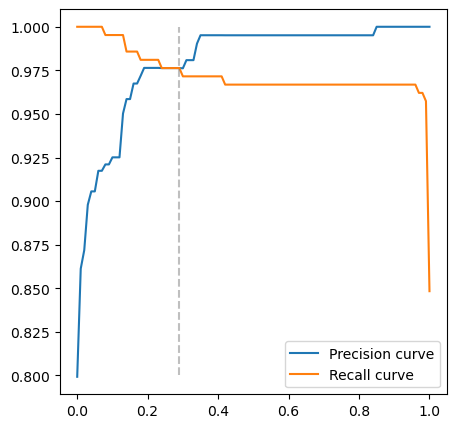

In [25]:
plt.figure(figsize=(5, 5))
plt.plot(df_scores.threshold, df_scores.p, label= "Precision curve")
plt.plot(df_scores.threshold, df_scores.r, label= "Recall curve")
plt.vlines(0.29, 0.8, 1, color='grey', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

### Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- **0.4**
- 0.6
- 0.7

In [26]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [27]:
df_scores[df_scores.f1 == max(df_scores.f1)]

,threshold,tp,fp,fn,tn,p,r,f1
35,0.35,205,1,6,52,0.995146,0.971564,0.983213
36,0.36,205,1,6,52,0.995146,0.971564,0.983213
37,0.37,205,1,6,52,0.995146,0.971564,0.983213
38,0.38,205,1,6,52,0.995146,0.971564,0.983213
39,0.39,205,1,6,52,0.995146,0.971564,0.983213
40,0.40,205,1,6,52,0.995146,0.971564,0.983213
41,0.41,205,1,6,52,0.995146,0.971564,0.983213


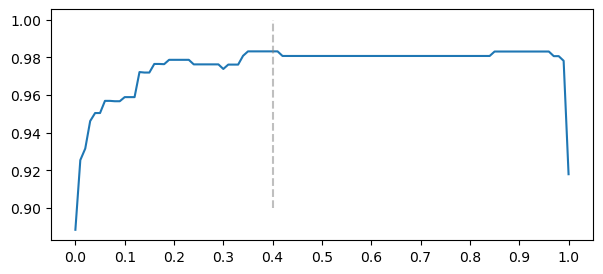

In [28]:
plt.figure(figsize=(7, 3))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.4, 0.9, 1, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

## Cross-validation framework
### Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- **0.003**
- 0.014
- 0.09
- 0.24

In [29]:
# Evaluating the same model on different subsets of data
# Getting the average prediction and the spread within predictions

from tqdm.auto import tqdm
from sklearn.model_selection import KFold

In [39]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [40]:
def train(df_train, y_train, C=1.0, max_iter=1000):
    dicts = df_train.to_dict(orient='records')
    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=max_iter)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df_val, dv, model):
    dicts = df_val.to_dict(orient='records')
    X_val = dv.transform(dicts)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    
    return y_pred
    

In [41]:
scores = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    
np.std(scores)

0.0

### Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- **1**
- 10

In [44]:
for c in [0.01, 0.1, 1, 10]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    
    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=c)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%s %.3f +- %.3f' % (c, np.mean(scores), np.std(scores)))

C=0.01 0.993 +- 0.005
C=0.1 0.999 +- 0.001
C=1 1.000 +- 0.000
C=10 1.000 +- 0.000
